### Импорт

In [53]:
import os
import sys
module_path = os.path.abspath(os.path.join('C:/Users/alex0/Documents/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import import_ipynb
from DS_modules import Models as mdl
from DS_modules import data_cleaning, data_preparation, EDA

#import to_test as TO_TEST
import re
from matplotlib import pyplot as plt

import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

import numpy as np
import pandas as pd
np.warnings.filterwarnings('ignore')

<IPython.core.display.Javascript object>

### Функции

In [54]:
def clean_rooms(df):
    df.loc[(df['Rooms'] < 1) & (df['LifeSquare'] < 30), 'Rooms'] = 1
    df.loc[(df['Rooms'] < 1) & (df['LifeSquare'] > 30) & (df['LifeSquare'] < 45), 'Rooms'] = 2
    df.loc[(df['Rooms'] < 1) & (df['LifeSquare'] > 45) & (df['LifeSquare'] < 60), 'Rooms'] = 3
    df.loc[(df['Rooms'] < 1) & (df['LifeSquare'] > 60) & (df['LifeSquare'] < 75), 'Rooms'] = 4
    df.loc[(df['Rooms'] < 1) & (df['LifeSquare'] > 70), 'Rooms'] = 5
    df.loc[(df['Rooms'] > 10), 'Rooms'] = 2
    df.loc[(df['Rooms'] == 1) & (df['LifeSquare'] > 150), 'Rooms'] = 3
    return df

In [55]:
def clean_square(df):
    df.loc[(df['Square'] > 300), 'Square'] = df.loc[(df['Square'] < 300), 'Square'].mode()[0]
    return df

In [56]:
def clean_life_square(df):
    mean_square_for_big = df.loc[df['LifeSquare'] > 250, 'Square'].mode()[0]
    df.loc[(df['LifeSquare'] < 5), 'LifeSquare'] = df['Square']*0.85
    df.loc[df['LifeSquare'] > 250, 'LifeSquare'] = df.loc[df['Square'] >= mean_square_for_big, 'LifeSquare'].mode()[0]
    #df.loc[(df['Square'] - df['LifeSquare']) > 50, 'LifeSquare'] = df.loc[(df['Square'] - df['LifeSquare']) > 50, 'Square']
    #df.loc[df['LifeSquare'] < 10, 'LifeSquare'] = df.loc[df['LifeSquare'] > 10, 'LifeSquare'].mode()[0]
    return df

In [57]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [58]:
def clean_kitchen_square(df):
    df.loc[(df['KitchenSquare'] > 100) |
       (df['KitchenSquare'] < 5), 'KitchenSquare'] = df.loc[df['KitchenSquare'] < 100, 'KitchenSquare'].mode()[0]
    return df

In [59]:
def clean_house_floor(df):
    df.loc[df['HouseFloor'] > 50, 'HouseFloor'] = df.loc[df['HouseFloor'] < 50, 'HouseFloor'].mode()[0]
    return df

In [60]:
def clean_data(df):
    df = clean_rooms(df)
    df = clean_square(df)
    df = clean_life_square(df)
    df = clean_kitchen_square(df)
    df = clean_house_floor(df)
    return df

### Загрузка данных

In [61]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

In [62]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

In [63]:
df, new_cols = data_preparation.do_cat_dummy(df)
df_test, new_cols = data_preparation.do_cat_dummy(df_test)

In [64]:
TARGET_NAME = 'Price'
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
BASE_FEATURE_NAMES = df[BASE_FEATURE_NAMES].columns.drop(['Id', 'Shops_2_ohe_B', 'Ecology_3_ohe_B', 'Ecology_2_ohe_B']).tolist()

### Обработка пропусков

In [65]:
df = data_cleaning.fill_nan_with_mode(df, ['LifeSquare', 'Healthcare_1'])
df_test = data_cleaning.fill_nan_with_mode(df_test, ['LifeSquare', 'Healthcare_1'])

### Обработка выбросов

In [66]:
df = clean_data(df)
df_test = clean_data(df_test)

In [67]:
df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = 2011
df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968

### Обзор признаков

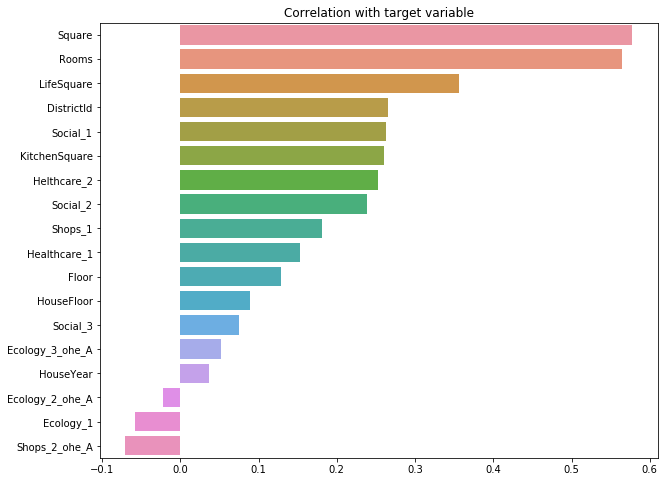

In [68]:
EDA.show_corr_bars(df, BASE_FEATURE_NAMES, TARGET_NAME)

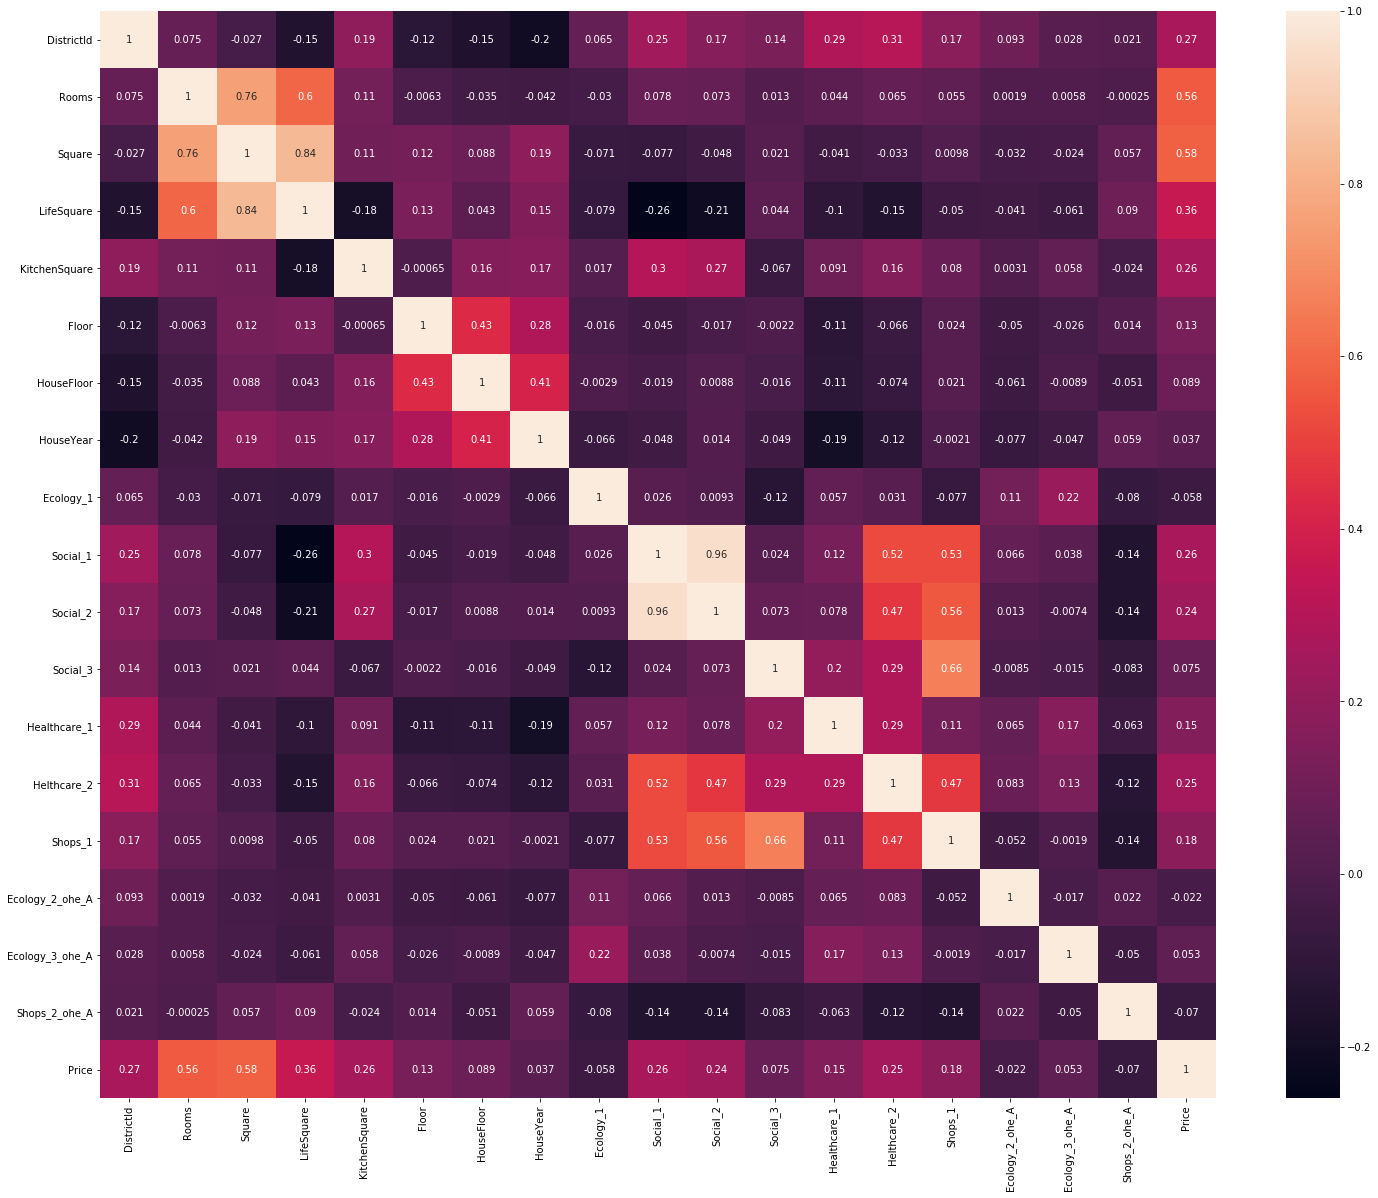

In [69]:
_data = BASE_FEATURE_NAMES.copy()
_data.append(TARGET_NAME)
EDA.show_heatmap(df, _data, True)

In [70]:
#EDA.show_multiple_pairplots(df, ['Floor', 'Rooms', 'DistrictId'], TARGET_NAME)

### Преобразование признаков

In [71]:
# unique_d_ids = df['DistrictId'].unique()

In [72]:
# for i in unique_d_ids:
#     mean_price = df.loc[df['DistrictId'] == i, 'Price'].mode()[0]
#     mean_price_log = np.sqrt(mean_price)
#     df.loc[df['DistrictId'] == i, 'MeanPriceByDisId'] = mean_price_log
#     df_test.loc[df_test['DistrictId'] == i, 'MeanPriceByDisId'] = mean_price_log

In [73]:
#BASE_FEATURE_NAMES.append('MeanPriceByDisId')

In [74]:
# df_test = data_cleaning.fill_nan_with_mode(df_test, ['MeanPriceByDisId'])

In [75]:
CAT_FEATURE_NAMES = ['Ecology_2_ohe_A', 'Shops_2_ohe_A', 'Ecology_3_ohe_A']
NOT_NUM_F = CAT_FEATURE_NAMES.copy()
NUM_FEATURE_NAMES = df[BASE_FEATURE_NAMES].columns.drop(NOT_NUM_F).tolist()

In [76]:
scaler = data_preparation.Standart_scaler()
df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])
df = df_norm.copy()

In [77]:
df_test_norm = df_test.copy()
df_test_norm[NUM_FEATURE_NAMES] = scaler.transform(df_test_norm[NUM_FEATURE_NAMES])
df_test = df_test_norm.copy()

In [78]:
X = df[BASE_FEATURE_NAMES]
y = df[TARGET_NAME]
X_train, X_test, y_train, y_test = data_preparation.tt_split(X, y, 0.3)

### Подбор моделей и настрока гиперпараметров

In [79]:
model_tester = mdl.ModelTester(X, y)

### Построение модели

In [80]:
catb_params = {'n_estimators':1700,
               'silent':True, 'random_state':42,
               'cat_features':[15,16, 17], 'l2_leaf_reg':2
}

rfr_params = {'n_estimators':2200, 
                'random_state':42, 'max_features':5, 
                'bootstrap':False, 'min_samples_leaf':2, 'min_samples_split':5}

In [81]:
model_catb = mdl.Catb(catb_params, "reg")

model_rfr = mdl.RF(rfr_params, "reg")

In [88]:
final_model = VotingRegressor([('RFR', model_rfr.model),
                               ('CATB', model_catb.model)], weights=[1,2])

In [89]:
final_model.fit(X_train, y_train)

VotingRegressor(estimators=[('RFR',
                             RandomForestRegressor(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features=5,
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=2,
                                                   min_samples_split=5,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=2200,
                                       

In [90]:
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
mdl.get_r2_score(y_train, y_train_pred, y_test, y_test_pred)

R2 score -  
TRAIN -  0.9377073978872568
TEST -  0.7543119303504405
----------------------------------------


### Обучение модели на всем датасете

In [48]:
final_model.fit(X, y)

VotingRegressor(estimators=[('RFR',
                             RandomForestRegressor(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features=5,
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=2,
                                                   min_samples_split=5,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=2200,
                                       

### Получение предсказаний

In [49]:
XX = df_test[BASE_FEATURE_NAMES]
YY = final_model.predict(XX)

In [50]:
df_test["Price"] = YY

In [51]:
df_test.loc[:, ['Id', 'Price']].to_csv('Kolch_predictions.csv', index=False)

In [52]:
!kaggle competitions submit -c realestatepriceprediction -m "" -f Kolch_predictions.csv

Successfully submitted to Real Estate Price Prediction



  0%|          | 0.00/122k [00:00<?, ?B/s]
100%|##########| 122k/122k [00:07<00:00, 16.7kB/s]
